In [3]:
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor

from utils import split_data_regression, add_coordinates

import warnings
warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = "all"

In [4]:
np.random.seed(42)

# Try to approximate theoretical maximum

We know, that $RSSI = 10 \lg \frac{P}{P_0}$

So, knowing, that intensity is the power transfered per unit area, and by having power in numenator and denominator, we can conclude, that $RSSI = 10 \lg \frac{\mathcal{I}}{\mathcal{I}_0}$  

Due to Inverse-square law we know, that $\mathcal{I} \propto \frac{1}{r^2}$:

So, $\mathcal{I} = \frac{c}{r^2}$

$RSSI = 10 \lg \mathcal{I} - 10 \lg \mathcal{I_0} = 
10 \lg{\frac{c}{r^2}} - 10 \lg{\mathcal{I_0}} =
-20 \lg{r} + 10 \lg{c} - 10 \lg{\mathcal{I_0}}$

Let's substitute $\mathcal{C} = 10 \lg{c} - 10 \lg{\mathcal{I_0}}$, as
it don't depends on distance and is constant


$RSSI = -20 \lg r + \mathcal{C}$  

So let's find the range of distance, that can correspond to same value of RSSI.  
We will use next charachteristics of kit (CY8CPROTO-063-BLE), that we are using:
 - Resolution in 1 db
 - Accuracy in 4 db

So we will create sequence of distance [0.01 - 10] m, 
and then finding corresponding RSSI. After that take floor of RSSI 
and then get rid of half of the RSSI bins between RSSI max and min values
to get +-2 accuracy.

In [5]:
def rssi_from_dist(d):
    return -20*np.log10(d)

vectorized_rssi_from_dist = np.vectorize(rssi_from_dist)

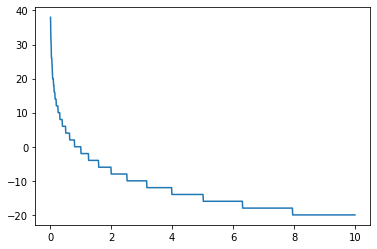

In [6]:
dist_bins = np.arange(0.01, 10, 0.01)
rssi_bins = vectorized_rssi_from_dist(dist_bins)
rssi_bins = np.floor(rssi_bins)

bins = np.arange(rssi_bins.min(), rssi_bins.max(), 2)

for i in range(rssi_bins.shape[0]):
    rssi_bins[i] = bins[abs(bins - rssi_bins[i]).argmin()]
    
sns.lineplot(x=dist_bins, y=rssi_bins)

# Regression

## Data processing

During classification we have encountered with problem, that information about correct/uncorrect squares are not enough for understanding. More naturaly for localization to see error, as difference between true point and predicted in 2D plain. To do so, we wanted to try Regression based approach, where we will be predicting **x** and **y** coordinates.

To do so we will use the fact, that while collecting data for fingerprinting 10 points where chosen not randomly but with next scheme:

![Subsquare division](./photos/fingerprinting_2/sub_square_division.png)

as square naturally divides into 9 points, we have done so, and tenth point was just measured a little bit lefter.

In [7]:
df = pd.read_csv('./data/fingerprinting_2.csv', index_col='Unnamed: 0')
df = df.reset_index(drop=True)

During the data gathering for 2 and 3 squares (s1 and s2) we have lost 1 orientation measurement (100 samples). As each subsequnt measurement is very similar to previous one and we don't use **Orientation** for predicting, then we can just duplicate the last 100 samples to have our data equable.

In [9]:
grouped = df.groupby("Square")

point1 = grouped.get_group("s1").iloc[-100:]
point1["Point"] = 39
point1["Orientation"] = 3.0

point2 = grouped.get_group("s2").iloc[-100:]
point2["Point"] = 39
point2["Orientation"] = 3.0

df = df.append([point1, point2]).reset_index(drop=True)

So, to get specific coordinates for each of 10 points in plain (for each we have measured 100 samples in 4 orientations) we will use next info:

- size of stool, on which was microcontroller was 40x40 cm
- stool was aligned to side of square or placed in center between two sides
- the order of points in square:
<pre>
  1    2    3
  8    9 10 4
  7    6    5
</pre>

In [12]:
df = add_coordinates(df)
df

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5,Square,Point,Orientation,x,y
0,-55,-71,-69,-57,-58,s0,0,0.0,20,380
1,-57,-64,-58,-48,-58,s0,0,0.0,20,380
2,-57,-64,-58,-48,-58,s0,0,0.0,20,380
3,-57,-64,-57,-48,-58,s0,0,0.0,20,380
4,-57,-65,-57,-48,-58,s0,0,0.0,20,380
...,...,...,...,...,...,...,...,...,...,...
48195,-64,-64,-74,-53,-35,s2,39,3.0,254,350
48196,-63,-65,-72,-53,-35,s2,39,3.0,254,350
48197,-63,-65,-72,-54,-35,s2,39,3.0,254,350
48198,-63,-65,-72,-53,-35,s2,39,3.0,254,350


In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data_regression(
    df, points_num=40, train_part=0.7, validation_part=0.15, test_part=0.15)

To handle, that we need to find **x** and **y** coordinates, we will use MultiOuputRegressor, which will just make one regressor for each target column

## Model

First, we wanted to use Decision based regression, as it is very similar to classification (it is actually classifacation), but model will divide continious space on bins by itself, so we don't need to think is it better to have square with 1 m side length or 10 cm.

In [17]:
model = MultiOutputRegressor(XGBRegressor(min_child_weight=2, max_depth=10))

model.fit(X_train, y_train)
predicted = model.predict(X_val)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=2, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                            rand

In [20]:
mean_absolute_error(y_val, predicted)

66.29709893716348

//TODO: Add visualizations

In [19]:
pd.DataFrame({"x": y_val["x"].values, 
              "y": y_val["y"].values,
              'predicted_x': predicted[:, 0], 
              'predicted_y': predicted[:, 1]}).iloc[:100]

,x,y,predicted_x,predicted_y
0,40,320,80.051346,189.628128
1,40,320,76.615173,302.347382
2,40,320,71.805153,297.889465
3,40,320,71.754280,294.852142
4,40,320,73.214645,287.504089
...,...,...,...,...
95,40,320,74.623985,319.025848
96,40,320,79.255249,286.644592
97,40,320,70.445801,294.084656
98,40,320,72.457169,300.666870


## Results